# Extracting a section from a DOCX file using LLMS and RAG

If your `DOCX` file is properly formatted, you do not need to do every step in this notebook. Current document analyzers such as `unstructured` or `docling` do a great job on that. However, there are cases where the `DOCX` files is not formatted using headings or titles, and in those cases, these tools will not solve the issue of extracting a specific section of the document.

In the case above, extracting the sections of the document with the code below would be a good solution.

```python
from docx import Document

def extract_sections(docx_file, keywords):
    doc = Document(docx_file)
    extracted_sections = {}
    current_heading = None

    for paragraph in doc.paragraphs:
        if paragraph.style.name.startswith('Heading'):
            current_heading = paragraph.text
        elif current_heading and any(keyword in paragraph.text.lower() for keyword in keywords):
            extracted_sections[current_heading] = extracted_sections.get(current_heading, '') + '\n' + paragraph.text

    return extracted_sections

```

However, we are focused on files where there is no section beginning with the formatting `paragraph.style.name.startswith('Heading')`.


# Imports and basic setup

In [1]:
from langchain_community.document_loaders.word_document import (
    UnstructuredWordDocumentLoader,
    Docx2txtLoader,
    )
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

import os

# If you want to hide your API keys in an .env file, do something like:
from dotenv import load_dotenv
load_dotenv()

# Example: set your OpenAI API key as an environment variable
#os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
# Now retrieve the token from environment variables
hf_token = os.getenv("HF_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Set the environment variable that huggingface_hub / transformers will look for
os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_token
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY


In [2]:
from glob import glob

DOCX_FILES = glob('./data/docx/*')
TRUTH_FILES = glob('./data/ground_truth/*')

# Organize the list of files making sure that the same file names are in the same index
DOCX_FILES.sort()
TRUTH_FILES.sort()

# Loading and Parsing the DOCX
LangChain’s default `UnstructuredFileLoader` will try to parse the file using Unstructured under the hood.

As seen in the another notebook, 

In [3]:
def extract_document_text(file, engine='docx2txt'):
    """
    Extracts the text from a document file.
    """
    if engine == 'docx2txt':
        loader = Docx2txtLoader(file)
        raw_documents = loader.load()
    elif engine == 'unstructured':
        loader = UnstructuredWordDocumentLoader(file)
        raw_documents = loader.load()
    else:
        raise ValueError('Invalid engine')
    return raw_documents

In [4]:
# raw_documents is a list of LangChain Document objects
raw_documents = extract_document_text(DOCX_FILES[0], engine='docx2txt')
print(f"Number of documents: {len(raw_documents)}")
print(raw_documents[0].page_content[:500])  # First 500 characters of the first doc


Number of documents: 1
Latrophilin-2 mediates fluid shear stress mechanotransduction at endothelial junctions







Keiichiro Tanaka1,7,*, Minghao Chen1,7, Andrew Prendergast1, Zhenwu Zhuang1, Ali Nasiri2, Divyesh Joshi1, Jared Hintzen1, Minhwan Chung1, Abhishek Kumar1, Arya Mani1, Anthony Koleske3, Jason Crawford4, Stefania Nicoli1 and Martin A. Schwartz1,5,6,*



1 Yale Cardiovascular Research Center, Section of Cardiovascular Medicine, Department of Internal Medicine, School of Medicine, Yale University, New Haven


In [5]:
# raw_documents is a list of LangChain Document objects
raw_documents = extract_document_text(DOCX_FILES[0], engine='unstructured')
print(f"Number of documents: {len(raw_documents)}")
print(raw_documents[0].page_content[:500])  # First 500 characters of the first doc


Number of documents: 1
Latrophilin-2 mediates fluid shear stress mechanotransduction at endothelial junctions

Keiichiro Tanaka1,7,*, Minghao Chen1,7, Andrew Prendergast1, Zhenwu Zhuang1, Ali Nasiri2, Divyesh Joshi1, Jared Hintzen1, Minhwan Chung1, Abhishek Kumar1, Arya Mani1, Anthony Koleske3, Jason Crawford4, Stefania Nicoli1 and Martin A. Schwartz1,5,6,*

1 Yale Cardiovascular Research Center, Section of Cardiovascular Medicine, Department of Internal Medicine, School of Medicine, Yale University, New Haven, CT 065


We can see a very important difference here, which is the time used by each cell to run. As showed in the `comparing_performance-extraction` notebook, the `docx2text` engine shows an order of magnitude faster extraction than the `unstructured` engine. For this reason, we will keep using `docx2text` in this notebook.

# Splitting into Chunks
We want to break the text into smaller chunks (so that each chunk is not too large for embeddings or retrieval). We can use `RecursiveCharacterTextSplitter`.

Here we are using ```RecursiveCharacterTextSplitter``` to split the text into chunks of 1024 characters. However, using a splitter based on `NLTKTextSplitter` or `SpacyTextSplitter` might be a good option to keep the chunks semantically meaningful.

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=768,   # characters per chunk
    chunk_overlap=64  # overlap for context
)

text_splitted = text_splitter.split_documents(raw_documents)

print(f"Number of chunks after splitting: {len(text_splitted)}")
print(text_splitted[6].page_content)  # A sample chunk


Number of chunks after splitting: 137
kinases (SFKs) within seconds, resulting in ligand-independent activation of VEGF receptors and downstream events including endothelial cell (EC) alignment in the direction of flow(Collins et al, 2012). However, the mechanisms by which proteins located at cell-cell junctions can sense forces from shear stress exerted on the apical surface is unclear. Previous work suggests that activation of the junctional complex is not primary but rather requires an upstream event, mediated presumably by another mechanosensor (Conway et al, 2013).


# Embedding the section into a vectorstore for RAG

We use here `HuggingFace`'s `sentence-transformers` to embed the text chunks into vectors. We then store these vectors in a `VectorStore` for RAG to use.

One question I always had regarding the embedding tokenizer and the RAG was whether we needed to prepare the embeddings using the same model or tokenizer used for the LLM inference. I asked this and obtained the following answer from ChatGPT:

**Embeddings vs. LLM Inference: They Don’t Have to Match**

In a typical “Retrieval-Augmented Generation” (RAG) flow:

* **Embeddings**: You take text chunks and convert them into embedding vectors (using, e.g., sentence-transformers/all-MiniLM-L6-v2).
* **Vector Store**: You store those embeddings in a vector database (e.g., Chroma).
* **Retrieval**: When a query arrives (e.g., “Give me the Data Availability statement”), you embed that query with the same embedding model and find the most similar chunks.
* **Generation**: You feed those retrieved chunks (as plain text) into your Large Language Model (LLM) to answer the query or provide the final text.
Because the LLM only sees or generates plain text, there’s no requirement that the LLM use the same tokenizer or embedding model you used for retrieval. They are effectively separate steps:

* Embedding Model → Produces vector embeddings
* LLM → Takes text, outputs text

Hence, you can absolutely use sentence-transformers/all-MiniLM-L6-v2 for embedding, and any local or remote LLM for the generation step—OpenAI’s GPT-4, Anthropic’s Claude, or a local Hugging Face model like Falcon, Mistral, LLaMA-2, etc.



In [7]:
# 1) Initialize the embedding model
from langchain.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# 2) Create (or load) a Chroma vector store
from langchain.vectorstores import Chroma

persist_directory = "./chroma_db"  # Where to store DB files on disk

# Build the vector store from our docs
vectorstore = Chroma.from_documents(
    documents=text_splitted,
    embedding=embedding_model,
    persist_directory=persist_directory
)


/var/folders/ps/jnmyqjq57sncdxvsr5297tk00000gq/T/ipykernel_37481/392184133.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/Users/jabreu/PycharmProjects/python-playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the LLM pipeline

In [8]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)



In [9]:
from langchain.llms.base import LLM
from typing import Optional, List, Any
import re

from langchain.llms.base import LLM
from pydantic import Field, BaseModel
from typing import Optional, List, Any

from langchain.llms.base import LLM
from pydantic import Field
from typing import Optional, List, Any

class CTransformersLLM(LLM):
    """
    A custom LangChain LLM wrapper around a ctransformers-based .gguf model.
    """

    ctransformers_model: Any = Field(default=None)
    temperature: float = Field(default=0.0)
    max_tokens: int = Field(default=256)

    class Config:
        # Let Pydantic store arbitrary Python objects (your ctransformers model).
        arbitrary_types_allowed = True

    def __init__(self, ctransformers_model: Any, **kwargs):
        """ 
        ctransformers_model: The loaded model from ctransformers.AutoModelForCausalLM. 
        """
        super().__init__(**kwargs)
        # Bypass pydantic's immutability checks:
        object.__setattr__(self, "ctransformers_model", ctransformers_model)
        object.__setattr__(self, "temperature", self.temperature)
        object.__setattr__(self, "max_tokens",  self.max_tokens)

    @property
    def _llm_type(self) -> str:
        """A short string identifying this LLM type."""
        return "ctransformers"

    def _call(self, prompt: str, stop: Optional[List[str]] = None, **kwargs: Any) -> str:
        """
        The main generation method that LangChain calls internally.
        `prompt` is the text prompt.
        `stop` is an optional list of stop tokens.
        """
        output = self.ctransformers_model(
            prompt,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
        )
        if stop:
            for token in stop:
                if token in output:
                    output = output.split(token)[0]
        return output

    @property
    def _identifying_params(self) -> dict:
        """
        Return a dictionary describing your model. 
        LangChain calls `dict(self._identifying_params)` internally.
        """
        return {
            "model_type": "ctransformers",
            "temperature": self.temperature,
            "max_tokens": self.max_tokens
        }


In [10]:
from ctransformers import AutoModelForCausalLM

# Replace with any GGUF model path/repo you want
model_id = "TheBloke/Mistral-7B-v0.1-GGUF"
model_file = "mistral-7b-v0.1.Q4_0.gguf"  # Example quant file name
model_type = "mistral"  # ctransformers needs to know the base model type
# model_id = "QuantFactory/Meta-Llama-3-8B-GGUF"
# model_file = "Meta-Llama-3-8B.Q4_0.gguf"
# model_type = "llama"  # ctransformers needs to know the base model type
# This downloads the .gguf file from HF (if not already cached)
llm = AutoModelForCausalLM.from_pretrained(
    model_id,
    model_file=model_file,
    model_type=model_type,  # ctransformers needs to know the base model type
    # or "llama" for Llama 2, etc.
    # Below are optional arguments:
    # gpu_layers=100% if you want MPS acceleration on macOS with Apple Silicon
    # or `gpu_layers=50` etc. The more layers you put on the GPU, the more VRAM is used.
    # For MPS on macOS, set:
    # force_download=True,  # If you want to force re-download
    gpu_layers=50,
    local_files_only=False # If True, won't download but only use local
)

# prompt = "Explain why 4-bit quantization is beneficial."
# output = llm(prompt, max_new_tokens=200)
# print(output)


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 5295.84it/s]


In [11]:
# Suppose `llm` is your ctransformers model
ctrans_llm = CTransformersLLM(
    ctransformers_model=llm,
    temperature=0.1,
    max_tokens=256
    )

# output = ctrans_llm("Explain the meaning of life in 20 words.")
# print(output)


# Build the retrieval QA chain

In [12]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredFileLoader

In [13]:
from langchain.chains import RetrievalQA

retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

qa_chain_local = RetrievalQA.from_chain_type(
    llm=ctrans_llm,         # Our ctransformers-based LLM
    chain_type="refine",    # "stuff", "refine", or "map_reduce"
    retriever=retriever,
)

# Example Queries
query = "Please provide the Data Availability statement from this document. Extract the estatemen exactly as it is written in the document. Make sure not to repeat the estatement twice."
response = qa_chain_local.invoke(query)



In [14]:
print("Data Availability estatement:\n", response["result"])

Data Availability estatement:
 
Data availability

The datasets produced in this study are available in the following databases:

All data: BioStudies S-BIAD928: https://www.ebi.ac.uk/biostudies/studies?query=S-BIAD928

Context information
------------
Given the context information and not prior knowledge, answer the question: Please provide the Data Availability statement from this document. Extract the estatemen exactly as it is written in the document. Make sure not to repeat the estatement twice.

Data availability

The datasets produced in this study are available in the following databases:

All data: BioStudies S-BIAD928: https://www.ebi.ac.uk/biostudies/studies?query=S-BIAD928

Context information
------------
Given the context information and not prior knowledge, answer the question: Please provide the Data Availability statement from this document. Extract the estatemen exactly as it is written in the document. Make sure not to repeat the estatement twice.

Data availability


# We check now how does the OpenAI performance with this method work

In [15]:
from langchain_openai import OpenAI

retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

openai_llm = OpenAI(
    model="gpt-3.5-turbo-instruct",
    temperature=0,
    max_retries=2,
    max_tokens=512,
    frequency_penalty=2
)

qa_chain_openai = RetrievalQA.from_chain_type(
    llm=openai_llm,         # Our ctransformers-based LLM
    chain_type="refine",    # "stuff", "refine", or "map_reduce"
    retriever=retriever,
)


In [16]:
# Example Queries
query = "Please provide the Data Availability statement from this document. Extract the estatemen exactly as it is written in the document. Make sure not to repeat the estatement twice."
response = qa_chain_openai.invoke(query)



In [17]:
print(response["result"])



Data Availability Statement:
The datasets used and/or analyzed during the current study are available from the corresponding author on reasonable request. Additionally, human genetic data linking the Adgrl2 gene to vascular disease can be found in Appendix fig. S10, but further population genetic analyses are needed to fully understand any causal connections between identified polymorphisms and vascular disease (Appendix fig. S11). More detailed population genetic analyses are required to address these issues.

Table 1: Primer sequences used for quantitative PCR in this study
Gene name Forward (5'-3') Reverse (5'-3') Human LPHN1 CAGTACGACTGTGTCCCCTACA GCACCATGCGCCAGACTG Human LPHN2 GTCCAATATGAATGTGTCCCTTACA GCACCAAGCACCCGCCTT Human LPHN3 GTGCAGTATGAATGTGTCCCTTACA GCACCACGCCCCAGATTG Human KLF2 CGGCAAGACCTACACCAAGA TGGTAGGGCTTCTCACCTGT Human GAPDH TGCACCACCAACTGC
Zebrafish LPHN1a C AGTA TG A AT G TG CC AT ACA AC ACC CAT GCC CCC CG ACT G Zebrafish beta-actin GA TC GG CA TC AC ACC TT CT 

**Ground truth**

```
Data availability
The datasets produced in this study are available in the following databases:
All data: BioStudies S-BIAD928: https://www.ebi.ac.uk/biostudies/studies?query=S-BIAD928
```

In [18]:
# Example Queries
query = """
    At the end of the document you will find the section of the figure legends or figure captions. 
    I want you to extrac literally as it is shown in the text the caption of Figure 1.
    
    Extract the text as it appears in the document.
"""
response = qa_chain_openai.invoke(query)



In [19]:
print(response["result"])



"Figure 1. Identification of the upstream GPCR for CXCL12-induced ERK activation in MDA-MB-231 cells. (A) Representative Western blot analysis showing phosphorylation of ERK1/2 in response to CXCL12 stimulation (100 ng/ml, 5 min) with or without pretreatment with pertussis toxin (PTX, 200 ng/ml). GAPDH was used as a loading control. Data are representative of three independent experiments."


**Ground truth**

```
    Figure 1. Gα proteins specific for endothelial flow responses
    A, Flow-induced endothelial alignment after Gα knockdown.  HUVECs were subjected to fluid shear stress (FSS) at a rate of 12 dynes/cm2 for 16 hours and nuclear orientation quantified as histograms showing the percentage of cells within each 10° of the flow directions from 0° to 90° (see Methods) ****: p<0.0001; one-way ANOVA with Tukey’s multiple comparisons test. B, Src family kinase activation, quantified in C. n=5 for control, Gi knockdown, Gq11 knockdown and n=3 for simultaneous knockdown of Gi and Gq11.  Values are means ± SEM. ****: p<0.0001, ***: p<0.001; one-way ANOVA with Tukey multiple comparison test.  D, Rescue of Gq/11 and Gi knockdown by re-expression of siRNA-resistant versions of the indicated proteins. ****: p<0.0001; one-way ANOVA with Tukey’s multiple comparison test. E, Amino acid sequences of Gαi1, Gαi2, and Gαi3 at the mutation sites of Gαi1 gain-of-function mutant.  F, Rescue of Gq/11 and Gi knockdown with indicated Gα proteins. Each point corresponds to one measurement averaged from >500 cells. N=4. ****: p<0.0001; one-way ANOVA with Tukey’s multiple comparisons test.  G, GINIP pulldown assay for activation of Gαi2 by FSS.  N=3. Results quantified in H.  **: p=0.0185, Student’s t-test.  I, GRK2N pulldown assay for activation of Gq.  N=4, quantified in J. *: p<0.05, Student’s t-test. K, GINIP pulldown assay for FSS-induced activation of wild type and Q306K Gαi1.  N = 4, quantified in L. *: p=0.0304, ***: p=0.0017; Student’s t-test. M, Gi2 activation after PECAM-1 knockdown. HUVECs expressing GluGlu tagged Gi2 were transfected with scrambled siRNA or PECAM-1 siRNA, exposed to FSS, and Gi2 activation assayed as described above, quantified in N. Values are means ± SEM, normalized to input Gα protein levels. ***: p<0.001; Student’s t-test, N=4.
```


Looks like the extraction of the `data availability` section, being short enough and likely not to be repeated for the rest of the paper, was successful. However, the extraction of the `Figure 1` section was not successful. This is likely due to the fact that the section is too long and the embeddings are not able to capture the entire section in a single chunk. Increasing the chunk size does not seem to help either, so we will stop pursuing the figure legend extraction in this way.

## Benchmarking `Data Availability` extraction

Now, having an open model and an Open AI model doing a similar task, we will average their extraction quality over the entire set of documents we have to see how reliable this method of extraction might be on the long term:

In [20]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=768,   # characters per chunk
    chunk_overlap=64  # overlap for context
)



In [21]:
from nltk.translate.bleu_score import sentence_bleu
# Reference text (the original or expected text)
reference = 'This is a sample reference sentence.'.split()

# Candidate text (the text you want to evaluate)
candidate = 'This is a sample candidate sentence.'.split()
# Calculate BLEU-1 score
score = sentence_bleu([reference], candidate, weights=(1, 0, 0, 0))

print(f'BLEU-1 score: {score:.4f}')

import re
# Function to remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)


BLEU-1 score: 0.8333


In [ ]:
import json
import uuid

scores_local, scores_openai = [], []

results = []

query = """
    Please provide the Data Availability statement from this document.
    Extract the estatemen exactly as it is written in the document. Make sure not to repeat the estatement twice.
    If you can not find any estatement, please provide the following answer:
    
    `This study includes no data deposited in external repositories.`
    """

openai_llm = OpenAI(
    model="gpt-3.5-turbo-instruct",
    temperature=0,
    max_retries=2,
    max_tokens=512,
    frequency_penalty=2
)

for docx, truth in zip(DOCX_FILES, TRUTH_FILES):
    print(f"Processing document: {docx}")
    
    with open(truth) as f:
        truth_data = json.load(f)

    truth_answer = truth_data["data_availability"]["section_text"]
    truth_answer = remove_html_tags(truth_answer)
    raw_documents = extract_document_text(docx, engine='docx2txt')
    text_splitted = text_splitter.split_documents(raw_documents)
    
    print("Split documents:", text_splitted)

    # Build vectorstore
    vectorstore = Chroma.from_documents(
        documents=text_splitted,
        embedding=embedding_model,
        persist_directory=None,  # No persistence
        collection_name=str(uuid.uuid4())  # ensure uniqueness
    )
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    
    # Debug retrieved documents
    retrieved_docs = retriever.get_relevant_documents(query)

    # QA chain
    qa_chain_openai = RetrievalQA.from_chain_type(
        llm=openai_llm,
        chain_type="refine",
        retriever=retriever,
    )
    qa_chain_local= RetrievalQA.from_chain_type(
        llm=ctrans_llm,         # Our ctransformers-based LLM
        chain_type="refine",    # "stuff", "refine", or "map_reduce"
        retriever=retriever,
    )
    response_openai = qa_chain_openai(query)
    response_local= qa_chain_local(query)
        
    # Evaluate
    score_openai = sentence_bleu([truth_answer], response_openai["result"], weights=(1, 0, 0, 0))
    scores_openai.append(score_openai)
    score_local = sentence_bleu([truth_answer], response_local["result"], weights=(1, 0, 0, 0))
    scores_local.append(score_local)
    
    results.append(
        {
            "truth": truth_answer,
            "openai": response_openai["result"],
            "local": response_local["result"],
        }
    )



Processing document: ./data/docx/EMBOJ-2023-114195.docx
Split documents: [Document(metadata={'source': './data/docx/EMBOJ-2023-114195.docx'}, page_content='Latrophilin-2 mediates fluid shear stress mechanotransduction at endothelial junctions\n\n\n\n\n\n\n\nKeiichiro Tanaka1,7,*, Minghao Chen1,7, Andrew Prendergast1, Zhenwu Zhuang1, Ali Nasiri2, Divyesh Joshi1, Jared Hintzen1, Minhwan Chung1, Abhishek Kumar1, Arya Mani1, Anthony Koleske3, Jason Crawford4, Stefania Nicoli1 and Martin A. Schwartz1,5,6,*\n\n\n\n1 Yale Cardiovascular Research Center, Section of Cardiovascular Medicine, Department of Internal Medicine, School of Medicine, Yale University, New Haven, CT 06511, USA\n\n2 Department of Internal Medicine\n\n3 Department of Molecular Biochemistry and Biophysics\n\n4 Department of Chemistry\n\n5 Department of Cell Biology\n\n6 Department of Biomedical Engineering \n\n7 These authors contributed equally.'), Document(metadata={'source': './data/docx/EMBOJ-2023-114195.docx'}, page_co

/var/folders/ps/jnmyqjq57sncdxvsr5297tk00000gq/T/ipykernel_37481/354113316.py:47: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)
/var/folders/ps/jnmyqjq57sncdxvsr5297tk00000gq/T/ipykernel_37481/354113316.py:60: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response_openai = qa_chain_openai(query)


Processing document: ./data/docx/EMBOJ-2023-114687.docx
Split documents: [Document(metadata={'source': './data/docx/EMBOJ-2023-114687.docx'}, page_content='The Nedd4L ubiquitin ligase is activated by FCHO2-generated membrane curvature\n\n\n\nYasuhisa Sakamoto1, Akiyoshi Uezu1, Koji Kikuchi1, Jangmi Kang2, Eiko Fujii2, Toshiro Moroishi3, Shiro Suetsugu4, and Hiroyuki Nakanishi1,2*\n\n\n\n1Department of Molecular Pharmacology, Faculty of Life Sciences, Kumamoto University, 1–1–1 Honjyo, Kumamoto 860-8556, Japan\n\n2Faculty of Clinical Nutrition and Dietetics, Konan Women’s University, 6–2–23 Morikita-machi, Kobe 658-0001, Japan\n\n3Department of Molecular and Medical Pharmacology, Faculty of Life Sciences, Kumamoto University, 1–1–1 Honjyo, Kumamoto 860-8556, Japan\n\n4Division of Biological Science, Graduate School of Science and Technology, Nara Institute of Science and Technology, 8916-5 Takayama-cho, Ikoma 630-0192, Japan'), Document(metadata={'source': './data/docx/EMBOJ-2023-114687

Number of tokens (513) exceeded maximum context length (512).
Number of tokens (514) exceeded maximum context length (512).
Number of tokens (515) exceeded maximum context length (512).
Number of tokens (516) exceeded maximum context length (512).
Number of tokens (517) exceeded maximum context length (512).
Number of tokens (518) exceeded maximum context length (512).
Number of tokens (519) exceeded maximum context length (512).
Number of tokens (520) exceeded maximum context length (512).
Number of tokens (521) exceeded maximum context length (512).
Number of tokens (522) exceeded maximum context length (512).
Number of tokens (523) exceeded maximum context length (512).
Number of tokens (524) exceeded maximum context length (512).
Number of tokens (525) exceeded maximum context length (512).
Number of tokens (526) exceeded maximum context length (512).
Number of tokens (527) exceeded maximum context length (512).
Number of tokens (528) exceeded maximum context length (512).
Number o

Processing document: ./data/docx/EMBOJ-2023-115537.docx
Split documents: [Document(metadata={'source': './data/docx/EMBOJ-2023-115537.docx'}, page_content='Autophagy adaptors mediate Parkin-dependent mitophagy by forming sheet-like liquid condensates\n\n\n\nZi Yang1,a, Saori R. Yoshii1, Yuji Sakai1,2,3,b, Jing Zhang1, Haruka Chino1,c, Roland L. Knorr1,4,d, Noboru Mizushima1,5*\n\n\n\n1Department of Biochemistry and Molecular Biology, Graduate School of Medicine, The University of Tokyo, Tokyo, Japan.\n\n2Department of Biosystems Science, Institute for Life and Medical Sciences, Kyoto University, Sakyo-ku, Kyoto, Japan\n\n3Interdisciplinary Theoretical and Mathematical Sciences (iTHEMS) Program, RIKEN, Wako, Saitama, Japan\n\n4Institute of Biology, Humboldt-Universität zu Berlin, Berlin, Germany\n\n5International Research Center for Neurointelligence (WPI-IRCN), UTIAS, The University of Tokyo, Tokyo, Japan'), Document(metadata={'source': './data/docx/EMBOJ-2023-115537.docx'}, page_conte

Number of tokens (513) exceeded maximum context length (512).
Number of tokens (514) exceeded maximum context length (512).
Number of tokens (515) exceeded maximum context length (512).
Number of tokens (516) exceeded maximum context length (512).
Number of tokens (517) exceeded maximum context length (512).
Number of tokens (518) exceeded maximum context length (512).
Number of tokens (519) exceeded maximum context length (512).
Number of tokens (520) exceeded maximum context length (512).
Number of tokens (521) exceeded maximum context length (512).
Number of tokens (522) exceeded maximum context length (512).
Number of tokens (523) exceeded maximum context length (512).
Number of tokens (524) exceeded maximum context length (512).
Number of tokens (525) exceeded maximum context length (512).
Number of tokens (526) exceeded maximum context length (512).
Number of tokens (527) exceeded maximum context length (512).
Number of tokens (528) exceeded maximum context length (512).
Number o

Processing document: ./data/docx/EMBOR-2024-59101V1-T.docx
Split documents: [Document(metadata={'source': './data/docx/EMBOR-2024-59101V1-T.docx'}, page_content='ER-to-lysosome-associated degradation\n\nacts as failsafe mechanism upon ERAD dysfunction\n\n\n\n\n\nElisa Fasana1+, Ilaria Fregno1+, Carmela Galli1+, Tatiana Soldà1 and Maurizio Molinari1,2*\n\n\n\n1Faculty of Biomedical Sciences, Institute for Research in Biomedicine, Università della Svizzera italiana (USI), 6500 Bellinzona, Switzerland\n\n2School of Life Sciences, École Polytechnique Fédérale de Lausanne, 1015 Lausanne, Switzerland\n\n\n\n+Equal contribution\n\n*Correspondence to: maurizio.molinari@irb.usi.ch'), Document(metadata={'source': './data/docx/EMBOR-2024-59101V1-T.docx'}, page_content='The endoplasmic reticulum (ER) produces proteins destined to organelles of the endocytic and secretory pathways, the plasma membrane, and the extracellular space. While native proteins are transported to their intra- or extra-cellu

/Users/jabreu/PycharmProjects/python-playground/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/jabreu/PycharmProjects/python-playground/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/jabreu/PycharmProjects/python-playground/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

Processing document: ./data/docx/MSB-2023-12087.docx
Split documents: [Document(metadata={'source': './data/docx/MSB-2023-12087.docx'}, page_content='What we can learn from deep space communication for reproducible bioimaging and data analysis \n\nTatiana Woller1,2, Christopher J. Cawthorne3, Romain Raymond Agnes Slootmaekers4, Ingrid Barcena Roig5, Alexander Botzki6, Sebastian Munck7,2,#. \n\nVIB Technology Training, Data Core, and VIB BioImaging Core, Ghent & Leuven, Belgium \n\nKU Leuven, Department of Neuroscience, Leuven, Belgium \n\nNuclear Medicine and Molecular Imaging, Department of Imaging and Pathology, KU Leuven, Leuven, Belgium \n\nNSANGA, 36 Pakenstraat, Leuven, 3001, Belgium \n\nSupport for Research Data Management (RDM), KU Leuven, Leuven, Belgium \n\nVIB Technology Training, Ghent, Belgium \n\nVIB BioImaging Core, Leuven, Belgium'), Document(metadata={'source': './data/docx/MSB-2023-12087.docx'}, page_content='VIB BioImaging Core, Leuven, Belgium \n\n# to whom correspo

/var/folders/ps/jnmyqjq57sncdxvsr5297tk00000gq/T/ipykernel_37481/2574596975.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Local Scores', 'OpenAI Scores'])


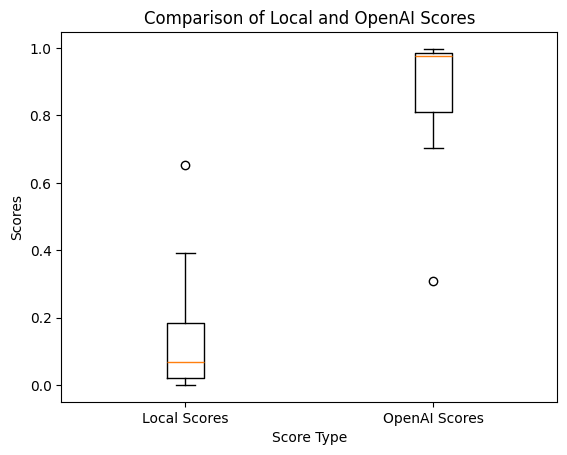

In [23]:
import matplotlib.pyplot as plt
# Combine the data into a list
data = [scores_local, scores_openai]

# Create a box plot
plt.boxplot(data, labels=['Local Scores', 'OpenAI Scores'])

# Add a title and labels
plt.title('Comparison of Local and OpenAI Scores')
plt.xlabel('Score Type')
plt.ylabel('Scores')

# Display the plot
plt.show()


In [24]:
import html
import difflib

    
def text_diff(expected, actual):
    # First unescape both texts
    expected = html.unescape(expected)
    actual = html.unescape(actual)
    
    matcher = difflib.SequenceMatcher(None, expected, actual)
    output = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            output.append(expected[i1:i2])
        elif tag == 'delete':
            output.append('\033[91m' + expected[i1:i2] + '\033[0m')
        elif tag == 'insert':
            output.append('\033[92m' + actual[j1:j2] + '\033[0m')
        elif tag == 'replace':
            output.append('\033[91m' + expected[i1:i2] + '\033[0m')
            output.append('\033[92m' + actual[j1:j2] + '\033[0m')
            
    return ''.join(output)



In [25]:
for result, paper in zip(results, DOCX_FILES):
    print(f"********{paper.split('/')[-1]}:********")
    print("gpt-3.5-turbo:", result["openai"], "\n\n")
    print("Comparison with ground truth: ", text_diff(result["truth"], result["openai"]))


********EMBOJ-2023-114195.docx:********
gpt-3.5-turbo: 
The datasets produced in this study are available in the following databases:

All data: BioStudies S-BIAD928: https://www.ebi.ac.uk/biostudies/studies?query=S-BIAD928 


Comparison with ground truth:  
The datasets produced in this study are available in the following databases: 

All data: BioStudies S-BIAD928: https://www.ebi.ac.uk/biostudies/studies?query=S-BIAD928
********EMBOJ-2023-114687.docx:********
gpt-3.5-turbo: 
This study includes no data deposited in external repositories. 


Comparison with ground truth:  
This study includes no data deposited in external repositories.
********EMBOJ-2023-115257.docx:********
gpt-3.5-turbo: 
The RNA-seq transcriptomics data on human bone biopsies have been deposited to BioProject with the dataset identifier PRJNA764663 (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA764663). The RNA-seq transcriptomics data on transfected osteoblasts have been deposited to GEO with the dataset identifi